# Vendor Masterfile EDA 

The vendor master file (VMF) is the repository of a considerable amount of information about a company's suppliers, which are used for the payment of supplier invoices and the issuance of purchase orders. Thorough analysis of VMF anomalies and tracing these anomalies to different data sources could reveal potential irregularities and fraudulent transactions.

This is a continuation of a [project](https://github.com/AmMoPy/VMF_ATP) I concluded earlier; the project was focused on creating a script to automate some audit test procedures and highlight irregularities in the underlying datasets to guide sampling and further analysis of these irregularities.

Underlying mock data sources are [Cagy](https://www.cagy.org/test-data-generator/?) and [Mockaroo](https://www.mockaroo.com/), manipulated to reflect real world examples. All simulated irregularities were actually driven from previous audits that I’ve performed.

In [180]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import tfidf_matcher as tm
import datetime as dt
import time
import calendar
from difflib import SequenceMatcher

%matplotlib inline

In [181]:
# Load data

vmf_df= pd.read_csv('VMF_vendor_list.csv', sep='\t', encoding='utf-16')
access_rights_df = pd.read_csv('VMF_access_rights.csv', sep='\t', encoding='utf-16').dropna(how='all')
employees_df = pd.read_csv('VMF_employee_list.csv', sep='\t', encoding='utf-16').dropna(how='all')
terminated_employees_df = pd.read_csv('VMF_terminated_employees.csv', sep='\t', encoding='utf-16').dropna(how='all')
po_df = pd.read_csv('VMF_po_list.csv', sep='\t', encoding='utf-16').dropna(how='all')

In [182]:
# Applying proper dtypes

vmf_df.name = vmf_df.name.astype(str)
vmf_df.creation_date = pd.to_datetime(vmf_df.creation_date)
vmf_df.modification_date = pd.to_datetime(vmf_df.modification_date)

employees_df.employee_name = employees_df.employee_name.astype(str)
employees_df.hiring_date = pd.to_datetime(employees_df.hiring_date)

terminated_employees_df.employee_name = terminated_employees_df.employee_name.astype(str)
terminated_employees_df.hiring_date = pd.to_datetime(terminated_employees_df.hiring_date)
terminated_employees_df.termination_date = pd.to_datetime(terminated_employees_df.termination_date)

po_df.po_date = pd.to_datetime(po_df.po_date)
po_df.po_total = po_df.po_total.str.replace(',', '').astype(int)

In [183]:
# Inspect Data
vmf_df.shape, access_rights_df.shape, employees_df.shape, terminated_employees_df.shape, po_df.shape

((1000, 13), (7, 3), (1000, 8), (1000, 10), (1000, 9))

In [184]:
vmf_df.sample(2)

,id,name,vendor_status,contact_name,payment_terms,phone,postal_code,address,taxpayer_identification_number_tin,creation_date,creation_user_id,modification_date,modification_user_id
127,100128,"Moen, Crona and O'Kon",Active,Isabella Strafford,n/30,160-957-9442,NaN,4 Graedel Road,NaN,2000-12-02 00:17:00,7752282,2005-10-27 17:39:00,8257920
389,100390,Rohan and Sons,Active,Garald Tewkesbury,n/30,415-815-4342,353254,4126 Raven Plaza,58-5379072,2001-11-11 03:41:00,8414231,2005-11-01 20:50:00,3069271


In [185]:
access_rights_df.sample(2)

,creation_user_id,modification_user_id,departement
4,8414231,3069271,Procurement
3,8264315,3709196,Procurement


In [186]:
employees_df.sample(2)

,employee_id,employee_name,hiring_date,departement,phone,postal_code,address,social_security_number_ssn
350,8496488,Malissia Bucklee,2015-12-27,Human Resources,198-312-3340,734 24,12632 Autumn Leaf Plaza,815-93-0092
442,2947376,Chen Pietesch,2009-06-24,Research and Development,415-258-1834,94121,42 Delladonna Road,393-03-4321


In [187]:
terminated_employees_df.sample(2)

,employee_id,employee_name,hiring_date,termination_date,termination_reason,departement,phone,postal_code,address,social_security_number_ssn
745,479841,Rudolfo Harse,2012-04-24,2021-10-27,Irresestable,Services,894-727-8832,NaN,2 Upham Alley,831-43-7547
768,9022631,Elfrida Blaasch,2008-06-18,2021-10-27,Resignation,Engineering,191-307-9719,NaN,30 Di Loreto Point,116-18-8602


In [188]:
po_df.sample(2)

,po_number,po_approval_status,po_status,po_date,item_description,vendor_name,total_quantity,currency,po_total
863,85702,Approved,Closed,2019-12-08,"Beef - Roasted, Cooked",Ortiz Inc,20.0,EUR,381690
434,40694,Approved,Closed,2019-03-25,"Crush - Grape, 355 Ml",Thiel-Labadie,18.0,EUR,765519


### Structure of the dataset:

There are 5 independent datasets as follows:
 - Vendor master file: Details of each vendor (ID, name, contact person, tax number, phone, address, etc...) and details about record creation and modification (creation/modification user ID and date)
 - Access rights: details (ID and department) of authorized personnel to create/modify vendor records
 - Active employees: details of active employees (name, ID, hiring date, department, etc...)
 - Terminated employees: details of terminated employees (name, ID, termination date, department, etc...)
 - Purchase Order (PO): details of POs for a given period (status, date, amount, item description, value, vendor, etc...)
 
### How do all these datasets link together?

Vendor master file is the main source from which vendor details can be extracted, it also represents the gateway for making related payments. In most cases payments cannot be made to vendors that are not recorded in the file, as for a vendor to be recorded in the master file a series of procedures and approvals are undertaken to ensure authenticity of such vendor and thus related payments.

Analysing the master file independently and in connection with the rest of the datasets will guide the efforts of ensuring that a company is making authentic payments and whether it has a well-established procurement practices.

### Purpose of this EDA:

Overall I need to conclude on the completeness and authenticity of vendor records and related transactions, I'd be interested in discovering and assessing whether the below anomalies exists and latter support or negate the conclusion by actual inspection of supporting documents:

1. Duplicate vendor (based on name and other details)
2. Missing vendor details
3. Inconsistent naming conventions and language usage
4. Unauthorized vendor record manipulation
5. Inappropriate access rights and employees’ modifying their own vendor records
6. Inactive vendors having recent POs
7. Purchasing same item from different suppliers with unjustified variations in unit price (missing volume discounts and directing purchases to specific suppliers)
8. Volume of transaction per each supplier (reveal potential kickbacks, thus reasoning needs proper investigation)

### Main feature(s) of interest in the dataset:

- Vendor details (name, ID, address, taxpayer identification number)
- Vendor record creation and modification details (Date, employee ID, employee department)
- PO details (item, vendor, value, date, status)

## Univariate Exploration

###  Is there a proper vendor registration process?

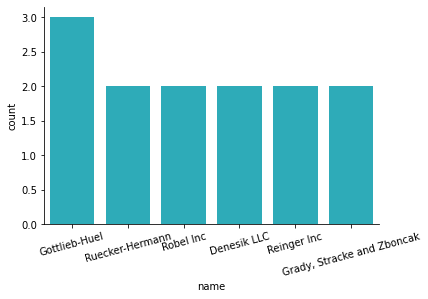

In [189]:
# Vendor records with exact duplicate vendor names

color = sb.color_palette()[9]

exact_dup_name = vmf_df[vmf_df.name.duplicated(keep=False)].name

sb.countplot(x = exact_dup_name, color = color)

plt.xticks(rotation = 15)
plt.gca().spines["top"].set_alpha(0.0); plt.gca().spines["right"].set_alpha(0.0)

In [190]:
vmf_df.id.duplicated().sum()

0

Since all IDs are unique we have 13 duplicated records with exact vendor name, this would be the starting point of further analysis of underlying details and related transactions

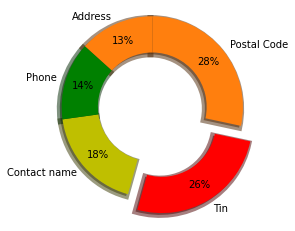

In [191]:
# missing vendor details

missing_details_count = vmf_df.isna().sum()

missing_details_count = missing_details_count[missing_details_count > 0].sort_values(ascending=False)

labels= ['Postal Code', 'Tin', 'Contact name', 'Phone', 'Address']

colors = ['tab:orange', 'r', 'y', 'g', 'tab:orange']

explode = [0, 0.2, 0, 0, 0]

plt.pie(missing_details_count, labels= labels, colors = colors, explode = explode, startangle= 90, 
        counterclock= False, wedgeprops={'width' : 0.4, 'linewidth': 6}, 
        autopct = lambda p: '{:.0f}%'.format(round(p)) if p > 0 else '', pctdistance = 0.8, shadow = True)

plt.axis('square');

it is customary that some details go missing due to input errors; However, nature of missing details signifies its importance. All records missing Tin numbers (taxpayer identification number) needs to be thoroughly investigated as these could be fictitious vendors, also in some regions companies get charged with taxes due on vendors they deal with incase the vendor commit tax evasion.

In [192]:
# vendor names exact and fuzzy matches with similarity scores

# finding exact and fuzzy matches between vendor names and calculating similarity scores to identify possible duplicates
# matching is based on specified n_gram and number of desired matches 'n_matches'.
# n_gram and n_matches default values are 3 and 10 respectively which mostly yield best results
# results are not filtered but are sorted in a descending order for convenience.


def similar(df, col1, col2):
    '''calculate similarities of returned results from tfidf matcher
    to facilitate filtering results'''
    return round(SequenceMatcher(None, df[col1], df[col2]).ratio(),2)

vendor_name = vmf_df.name.tolist()

match_name = vmf_df.name.tolist()

vn_name_match_df=tm.matcher(vendor_name , match_name, ngram_length= 3, k_matches= 10)

vn_name_match_df=pd.merge(vn_name_match_df,vmf_df[['id']], left_index=True,right_index=True,how='left')

vn_name_match_df.drop_duplicates(subset='Original Name', inplace=True)

vn_name_match_df.drop(columns=['Match Confidence','Lookup 1'], inplace=True)

vn_name_match_df.reset_index(drop=True, inplace=True)

vn_name_match_df=vn_name_match_df.melt(id_vars=["Original Name", 'id'],ignore_index=False)

vn_name_match_df.drop(columns=['variable'], inplace=True)

vn_name_match_df.reset_index(drop=True, inplace=True)

vn_name_match_df['similarity']=vn_name_match_df.apply(similar,args=('Original Name', 'value'),axis=1)

vn_name_match_df.index=vn_name_match_df.value

vmf_df.index=vmf_df.name

# collecting vendor details for matched vendors
vn_name_match_df=pd.merge(vn_name_match_df,vmf_df[['id','vendor_status']], left_index=True,right_index=True,how='left')

vn_name_match_df.reset_index(drop=True, inplace=True)

vmf_df.reset_index(drop=True, inplace=True)

# remove duplicate records
temp_df=vn_name_match_df.groupby(['id_x','Original Name', 'id_y', 'value', 'similarity', 'vendor_status'])['value'].count().to_frame()

vn_name_match_df= temp_df.index.to_frame()

vn_name_match_df.reset_index(drop=True, inplace=True)

# remove exact id matches
vn_name_match_df=vn_name_match_df[vn_name_match_df.id_x != vn_name_match_df.id_y]

vn_name_match_df[['id_x','id_y']] = vn_name_match_df[['id_x','id_y']].astype(str)

# removing reverse duplicate matches to eliminate data redundancy, 
# i.e: match result of x,y and y,x basically refer to same records
# first we join and sort both vendor ids to create a unique value for each result
# then drop duplicate joined ids
vn_name_match_df['reverse_duplicates'] = vn_name_match_df.apply(lambda row: ''.join(sorted([row.id_x, row.id_y])), axis=1)

vn_name_match_df.drop_duplicates(subset='reverse_duplicates', inplace=True)

vn_name_match_df.drop(columns='reverse_duplicates', inplace=True)

vn_name_match_df.reset_index(drop=True, inplace=True)

# collecting all match vendor details and sorting data for better view and comparison
vn_name_match_df[['id_x','id_y']] = vn_name_match_df[['id_x','id_y']].astype(float)

vn_name_match_df.rename(columns={'id_x':'id','Original Name':'name'}, inplace=True)

vn_name_match_df=pd.merge(vn_name_match_df,vmf_df[['id', 'phone', 'postal_code', 'address', 
                                                   'taxpayer_identification_number_tin']], on='id', how='left')

vn_name_match_df.rename(columns={'id':'vendor_id','name':'vendor_name','phone':'vendor_phone', 
                                 'postal_code':'vendor_postal_code', 'address':'vendor_address', 
                                 'taxpayer_identification_number_tin':'vendor_tin'}, inplace=True)

vn_name_match_df.rename(columns={'id_y':'id','value':'name'}, inplace=True)

vn_name_match_df=pd.merge(vn_name_match_df,vmf_df[['id', 'phone', 'postal_code', 'address', 
                                                   'taxpayer_identification_number_tin']], on='id', how='left')

vn_name_match_df.rename(columns={'id':'match_vendor_id', 'name':'match_vendor_name', 'phone':'match_vendor_phone', 
                                 'postal_code':'match_vendor_postal_code', 'address':'match_vendor_address', 
                                 'taxpayer_identification_number_tin':'match_vendor_tin'}, inplace=True)

result_columns=vn_name_match_df.columns.tolist()

columns_sort=result_columns[:2]+result_columns[3:4]+result_columns[2:3]+result_columns[4:6]+result_columns[6:7] \
+result_columns[10:11]+result_columns[7:8]+result_columns[11:12]+result_columns[8:9]+result_columns[12:13] \
+result_columns[9:10]+result_columns[13:]

vn_name_match_df=vn_name_match_df[columns_sort].sort_values(by='similarity', ascending=False)

r1 = vn_name_match_df.copy()

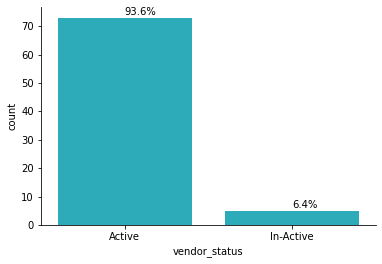

In [193]:
# Narrowing down results to highest similarity of vendor names (above 80%)
# and checking status

similarity_filter = r1[r1.similarity > 0.8]

sb.countplot(x = similarity_filter.vendor_status, color = color)

for i in range(similarity_filter.vendor_status.value_counts().shape[0]):
    count = similarity_filter.vendor_status.value_counts()[i] 
    prop = '{:0.1f}%'.format(100 * count / similarity_filter.vendor_status.count())
    plt.text(i,count+2, prop, va = 'center')

plt.xticks(rotation = None)
plt.gca().spines["top"].set_alpha(0.0); plt.gca().spines["right"].set_alpha(0.0)

94 % of vendor’s records that have high similarity across names are active! Sampling and inspection of registration supporting documents is warranted and also tracing these vendors to PO list and related payments.

In [194]:
# calcualting similarites across all details (phone, address, posta, tin, etc...) of filtered records

def similar_with_nan(df, col1, col2):
    '''calculate similarities between two dataframe columns while ignoring nan values'''
    if not df[[col1,col2]].isnull().any():
        return round(SequenceMatcher(None, df[col1], df[col2]).ratio(),2)
    else:
        return 0

temp_vn_df = r1.copy()

temp_vn_df = temp_vn_df[temp_vn_df.similarity >= .8]

for i, e in zip(*[iter(temp_vn_df.columns[6:])] * 2):
    print('matching' + ' ' + i + ' ' + 'with' + ' ' + e)
    result = temp_vn_df.apply(similar_with_nan,args=(i,e),axis=1)
    temp_vn_df[i] = result
    temp_vn_df.drop(columns=e,inplace=True)

temp_vn_df['total_similarity_score'] = temp_vn_df['similarity'] + temp_vn_df.iloc[:,-5:-1].sum(axis=1)

r2 = temp_vn_df.copy().sort_values(by='total_similarity_score', ascending=False)

# summary of similarity across all vendor details,
# only exact name duplicates and highest total similarities across all details are considered,
# score of 2 and above provided best result filter. I wanna highlight fuzzy duplicates that are 
# a highly possible match, as exact matches are already clear

r3 = r2[r2.total_similarity_score >= 2]

r3 = r3[r3.columns[0:4]]

r3.reset_index(drop=True, inplace=True)

matching vendor_phone with match_vendor_phone
matching vendor_postal_code with match_vendor_postal_code
matching vendor_address with match_vendor_address
matching vendor_tin with match_vendor_tin


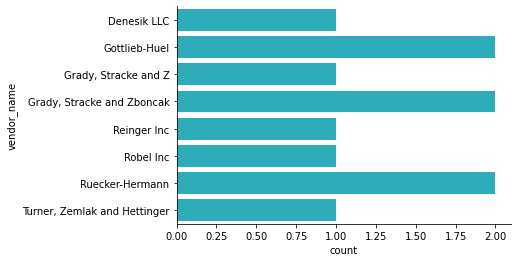

In [195]:
# PLotting number of records with highest similarity across all vendor details

order = r3.vendor_name.value_counts().index.sort_values()

sb.countplot(y = r3.vendor_name, color = color, order = order)

plt.gca().spines["top"].set_alpha(0.0); plt.gca().spines["right"].set_alpha(0.0)

These vendor records are most probably duplicates given the high similarity across all details. 

In [196]:
r2[r2.vendor_name == 'Gottlieb-Huel']

,vendor_id,vendor_name,match_vendor_name,match_vendor_id,similarity,vendor_status,vendor_phone,vendor_postal_code,vendor_address,vendor_tin,total_similarity_score
0,100001.0,Gottlieb-Huel,Gottlieb Huel Inc,100017.0,0.80,Active,1.00,1.00,1.00,1.0,3.80
1,100001.0,Gottlieb-Huel,Gottlieb-Hul,100137.0,0.96,Active,1.00,0.00,1.00,0.0,2.96
4,100001.0,Gottlieb-Huel,Gotlieb-H,100520.0,0.82,Active,0.50,0.00,0.59,0.0,1.91
6,100001.0,Gottlieb-Huel,Gottlieb-Huel,100702.0,1.00,Active,0.33,0.18,0.21,0.0,1.72
3,100001.0,Gottlieb-Huel,Gottlieb-Huel,100425.0,1.00,Active,0.00,0.22,0.30,0.0,1.52


We can observe that vendor registration process does not follow a systematic approach due to the following:
- Usage of different naming conventions
- Duplicate active vendor records
- Missing vendor details
 
Also, the ERP system (assuming that there is one) does not detect duplicated vendor details. Taking the vendor 'Gottlieb-Huel' as an example, two of the unique duplicate records (index 0 and 1) had exact vendor phone and address. It also shows that users who register vendors don't perform initial check to confirm existence of vendors prior to registration or use unified naming conventions.

### Are access rights properly enforced?

In [197]:
# access rights review
# identify any unauthorized record manipulation
# by comparing edit history to approved access rights and employee records

# building the dataframe of unauthorized access rights either modification of creation
creation_temp_df = vmf_df[~vmf_df.creation_user_id.isin(access_rights_df.creation_user_id)]

modification_temp_df = vmf_df[~vmf_df.modification_user_id.isin(access_rights_df.modification_user_id)]

access_rights_review_df = creation_temp_df.append(modification_temp_df)

access_rights_review_df.reset_index(drop=True, inplace=True)

employees_df['employee_status'] = 'Active'

terminated_employees_df['employee_status'] = 'Terminated'

# adjusting column length to exact match in both dataframes
fltrt_term_df=terminated_employees_df[employees_df.columns]

temp_employee_df=employees_df.append(fltrt_term_df)

# collecting all active/terminated employee details and sorting data for better view and comparison
access_rights_review_df.index=access_rights_review_df.creation_user_id

temp_employee_df.index=temp_employee_df.employee_id

access_rights_review_df=pd.merge(access_rights_review_df,temp_employee_df[['departement', 'employee_status', 'employee_name']],
                                 left_index=True, right_index=True, how='left')

access_rights_review_df.rename(columns={'departement':'creation_user_departement', 'employee_status':'creation_user_status', 
                                        'employee_name':'creation_user_name'}, inplace=True)

access_rights_review_df.index=access_rights_review_df.modification_user_id

access_rights_review_df=pd.merge(access_rights_review_df,temp_employee_df[['departement', 'employee_status', 'employee_name']],
                                 left_index=True, right_index=True, how='left')

access_rights_review_df.rename(columns={'departement':'modification_user_departement', 
                                        'employee_status':'modification_user_status', 'employee_name':'modification_user_name',
                                        'id':'vendor_id', 'name':'vendor_name'}, inplace=True)

# mapping termination date to terminated employees
for i in access_rights_review_df.creation_user_id.unique():
    term_date_dict=terminated_employees_df.set_index('employee_id').to_dict()['termination_date']
    
    if i in terminated_employees_df.employee_id.values:
        access_rights_review_df['termination_date']=access_rights_review_df.creation_user_id.map(term_date_dict)
    else:
        access_rights_review_df['termination_date']=access_rights_review_df.modification_user_id.map(term_date_dict)

access_rights_review_df.drop_duplicates(subset = 'vendor_id', inplace =True)

access_rights_review_df.reset_index(drop=True, inplace=True)

temp_employee_df.reset_index(drop=True, inplace=True)
    
result_columns=access_rights_review_df.columns.tolist()

columns_sort=result_columns[0:3]+result_columns[9:10]+result_columns[11:12]+result_columns[14:15]+result_columns[17:18] \
+result_columns[19:]+result_columns[10:11]+result_columns[13:14]+result_columns[15:16]+result_columns[12:13] \
+result_columns[16:17]+result_columns[18:19]

access_rights_review_df = access_rights_review_df[columns_sort]

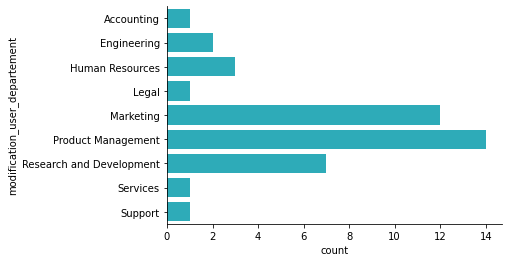

In [198]:
# filtering only unauthorized edits (both creation and modification)

unauthorized_cr = access_rights_review_df[~(access_rights_review_df.creation_user_id.isin(access_rights_df.creation_user_id))]

unauthorized_mod = access_rights_review_df[~(access_rights_review_df.modification_user_id.isin(access_rights_df.modification_user_id))]

# sort by department
order = unauthorized_mod.modification_user_departement.value_counts().index.sort_values()

sb.countplot(y = unauthorized_mod.modification_user_departement, color = color, order = order)

plt.gca().spines["top"].set_alpha(0.0); plt.gca().spines["right"].set_alpha(0.0)

Access rights controls are not properly enforced, as several departments can do unauthorized edits on the master file. **Actually, this type of observation might not be isolated and requires full review of domain security policies (Group Policy Settings); there might be failure to enforce group policies on local machines which could lead to internal breaches.**

In [199]:
# Identifying Employees editing their own vendor records
# both exact and fuzzy name matches are considered
# results are filtered to the nearest match
# using names instead of id as employees have two unique ids one as vendor and other as name

access_rights_review_df['similarity_creation'] = access_rights_review_df.apply(similar,args=('vendor_name', 'creation_user_name'),axis=1)

access_rights_review_df['similarity_modification'] = access_rights_review_df.apply(similar,args=('vendor_name', 'modification_user_name'),axis=1)

r4 = access_rights_review_df[(access_rights_review_df.similarity_creation >= .6) | 
                           (access_rights_review_df.similarity_modification >= .6)]

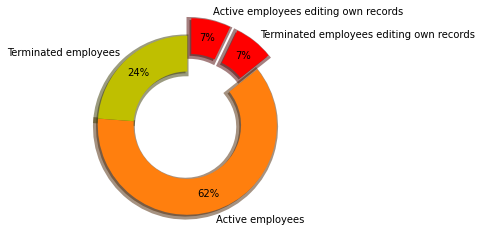

In [200]:
# plotting modifications activity

total_unauth_mods = access_rights_review_df.vendor_id.count()

own_record_active = r4.groupby(['modification_user_status']).size()[0]

own_record_terminated = r4.groupby(['modification_user_status']).size()[1]

active = unauthorized_cr.groupby(['modification_user_status']).size()[0] + unauthorized_mod[
    ~unauthorized_mod.creation_user_id.isin(unauthorized_cr.creation_user_id)].groupby(['modification_user_status']).size()[0]

terminated = total_unauth_mods - active

# -3 represents employees already considered in own record calculation
props = [own_record_active, own_record_terminated, active -3 , terminated -3]

labels= ['Active employees editing own records', 'Terminated employees editing own records', 
         'Active employees', 'Terminated employees']

colors = ['r', 'r', 'tab:orange', 'y']

explode = [0.2,0.2, 0, 0]

plt.pie(props, labels= labels, colors = colors, explode = explode, startangle= 90, 
        counterclock= False, wedgeprops={'width' : 0.4, 'linewidth': 6}, 
        autopct=lambda p: '{:.0f}%'.format(round(p)) if p > 0 else '', pctdistance = 0.8, shadow = True)

plt.axis('square');

Employees editing own records calls for immediate corrective actions.

In [201]:
# Terminated employees modifying own records after termination date
access_rights_review_df[access_rights_review_df.termination_date < access_rights_review_df.modification_date]

,vendor_id,vendor_name,vendor_status,creation_date,modification_date,creation_user_status,modification_user_status,termination_date,creation_user_id,creation_user_departement,creation_user_name,modification_user_id,modification_user_departement,modification_user_name,similarity_creation,similarity_modification
4,100891,Katrina Fells,Active,2001-11-16 10:24:00,2018-12-29 01:50:00,Active,Terminated,2005-10-27,7752282,Accounting,Tildie Pitkethly,1963374,Services,Katrina Fells,0.21,1.0
14,100825,Mab Speer,Active,2002-06-14 20:15:00,2018-12-29 01:50:00,Active,Terminated,2015-10-27,2682221,Procurement,Graeme Marqyes,6549024,Support,Mab Speer,0.26,1.0
27,100867,Quillan Wilkin,Active,2000-07-08 20:25:00,2018-12-29 01:50:00,Active,Terminated,2007-10-27,2682221,Procurement,Graeme Marqyes,9144916,Legal,Quillan Wilkin,0.14,1.0


It’s clear that access rights are not properly managed. A total of 42 records were modified by unauthorized personnel of which 62% are active employees; product management department had most edits followed by marketing and R&D departments respectively. Although access rights are already predefined, it might not be enforced or users can bypass.

User account management is also experiencing a significant control weakness as 3 records were edited by personnel after their termination data, this implies that they either still have access to company's network or their accounts were not deactivated after their termination and are used by internal users.

## Bivariate Exploration

### Are there transactions with potential duplicate vendors?

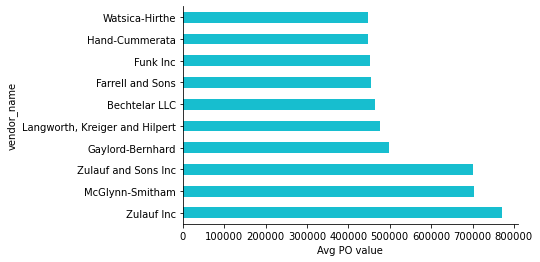

In [202]:
# plotting volume of transactions based on average of PO issed to vendors
# selecting to 10 highest values

po_df.groupby('vendor_name')['po_total'].mean().sort_values(ascending=False).head(10).plot(kind = 'barh', color = color)

plt.xlabel('Avg PO value')

plt.gca().spines["top"].set_alpha(0.0); plt.gca().spines["right"].set_alpha(0.0)

Two potential duplicate vendors can be noted 'Zulauf and Sons Inc', 'Zulauf Inc'. Inspection of related transactions should take priority.

In [203]:
# Checking similarity results of suspected vendor records as noted from plot above

r1[(r1.vendor_name == 'Zulauf and Sons Inc') | 
   (r1.vendor_name == 'Zulauf Inc')].sort_values(by = 'similarity', ascending = False).head(1)

,vendor_id,vendor_name,match_vendor_name,match_vendor_id,similarity,vendor_status,vendor_phone,match_vendor_phone,vendor_postal_code,match_vendor_postal_code,vendor_address,match_vendor_address,vendor_tin,match_vendor_tin
2488,100313.0,Zulauf Inc,Zulauf and Sons Inc,100339.0,0.69,Active,169-848-6994,NaN,NaN,NaN,32131 Melody Avenue,32131 Melody Avenue,95-0310595,71-8030241


In [204]:
# Checking thier PO status
po_df[(po_df.vendor_name == 'Zulauf and Sons Inc') | 
      (po_df.vendor_name == 'Zulauf Inc')]

,po_number,po_approval_status,po_status,po_date,item_description,vendor_name,total_quantity,currency,po_total
208,20071,Approved,Closed,2018-04-03,Pork Ham Prager,Zulauf and Sons Inc,1.0,EUR,701688
380,34439,Approved,Closed,2020-10-16,Milk - 2% 250 Ml,Zulauf Inc,3.0,EUR,770874


In [205]:
# checking PO issued to previously identified observations of duplicate vendors names and terminated employees
# other than the ones noted above

# 1st filter of similarity in vendor names above 80%
dup_ven = po_df[po_df.vendor_name.isin(similarity_filter.vendor_name)]

term_empl = po_df[po_df.vendor_name.isin(r4.vendor_name)]

dup_ven.vendor_name.value_counts() , term_empl.vendor_name.value_counts()

(Nader and Sons    25
 Wehner-Kessler    24
 Name: vendor_name, dtype: int64,
 Quillan Wilkin    6
 Katrina Fells     6
 Mab Speer         5
 Name: vendor_name, dtype: int64)

In [206]:
# inspect first filter result

similarity_filter[(similarity_filter.vendor_name == 'Nader and Sons') | 
                  (similarity_filter.vendor_name == 'Wehner-Kessler')]

,vendor_id,vendor_name,match_vendor_name,match_vendor_id,similarity,vendor_status,vendor_phone,match_vendor_phone,vendor_postal_code,match_vendor_postal_code,vendor_address,match_vendor_address,vendor_tin,match_vendor_tin
2346,100293.0,Wehner-Kessler,Ledner-Kessler,100477.0,0.86,Active,576-217-3711,438-881-9211,6419,NaN,NaN,54 Loomis Court,66-1903451,38-7120345
1541,100184.0,Nader and Sons,Sauer and Sons,100464.0,0.86,Active,957-220-8714,360-868-1430,NaN,349-1148,2 Coleman Terrace,07 East Plaza,NaN,92-8625563
1543,100184.0,Nader and Sons,Parker and Sons,100704.0,0.83,Active,957-220-8714,NaN,NaN,76200,2 Coleman Terrace,NaN,NaN,30-0113140


In [207]:
# checking whether these vendors were among highest similarity scores across all vendor details (2nd filter)
# the idea of using two filters is that matching and similarities does not produce perfect results
# and during exploration we don't want to jump to conclusion on authenticity of each vendor prior sampling and 
# document inspection, however these two vendors appear to be independent

r3[(r3.vendor_name == 'Nader and Sons') | 
   (r3.vendor_name == 'Wehner-Kessler')]

,vendor_id,vendor_name,match_vendor_name,match_vendor_id


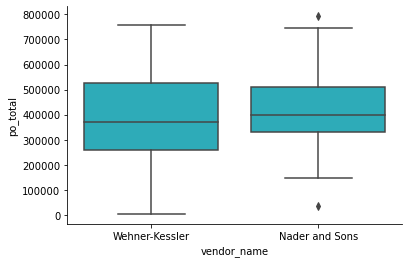

In [208]:
# comparing volume of transactions for theses two vendors

sb.boxplot(x = dup_ven.vendor_name, y = dup_ven.po_total, color = color);

plt.gca().spines["top"].set_alpha(0.0); plt.gca().spines["right"].set_alpha(0.0)

Nader and Sons's purchases tend to be of higher value than Wehner's with few outliers given that both have almost same number of transactions and purchase median is slightly higher for Nader than Whener. A further look into unit price variation can elaborate on this. 

In [209]:
# inspecting individual transactions and calculating unit price per each PO

po_df['unit_price'] = po_df.po_total / po_df.total_quantity

po_df['unit_price'] = po_df['unit_price'].astype(int)

po_df[(po_df.vendor_name == 'Nader and Sons') | 
      (po_df.vendor_name == 'Wehner-Kessler') & 
      (po_df.item_description.duplicated())].sort_values(by = 'item_description').head(10)

,po_number,po_approval_status,po_status,po_date,item_description,vendor_name,total_quantity,currency,po_total,unit_price
413,37850,Approved,Closed,2020-03-15,"Artichoke - Bottom, Canned",Nader and Sons,30.0,EUR,404418,13480
185,17802,Approved,Closed,2019-09-07,Beans - Fava Fresh,Nader and Sons,15.0,EUR,471146,31409
579,54033,Approved,Closed,2018-07-12,Bowl 12 Oz - Showcase 92012,Nader and Sons,5.0,EUR,211182,42236
955,95292,Approved,Closed,2018-04-14,"Capon - Breast, Double, Wing On",Wehner-Kessler,3.0,EUR,691949,230649
485,45740,Approved,Closed,2020-05-08,Cheese - Colby,Nader and Sons,6.0,EUR,745799,124299
504,47187,Approved,Closed,2019-11-30,Cheese - Shred Cheddar / Mozza,Nader and Sons,2.0,EUR,400390,200195
109,10200,Approved,Closed,2018-11-08,Cocoa Feuilletine,Nader and Sons,10.0,EUR,231375,23137
502,47116,Approved,Closed,2019-09-11,Cocoa Feuilletine,Wehner-Kessler,1000.0,EUR,434905,434
90,8282,Approved,Closed,2020-01-15,Creme De Menth - White,Nader and Sons,75.0,EUR,792110,10561
433,40646,Approved,Closed,2019-05-11,Ecolab Crystal Fusion,Nader and Sons,15.0,EUR,35104,2340


The similarity score between names of both vendors ('Zulauf and Sons Inc', 'Zulauf Inc') having highest avg PO values (first bar plot) suggest that if we are to sample and inspect supporting documents of suspected records we need to increase our search criteria to include similarities lower than 80% which was our initial filter. Moreover, we can't really rely on total similarity score of vendor details as a lot of data are missing and could lead to unrepresentative samples. So it is better to start our investigation at a lower threshold of similarity scores.

The volume of transactions of these two vendors is not high in terms of transaction number rather than value, given the period between the two transactions it suggests that the vendor may have changed his commercial name which needs to be verified by appropriate supporting evidence.

Nader and Sons's purchases (box plot) tend to be of higher value than Wehner's with few outliers given that both have almost same number of transactions and purchase median is slightly higher for Nader than Whener. Variation in unit prices of same items purchased from these two vendors is alarming and deems further investigation across other several vendors. Taking 'Cocoa Feuilletine' as an example (index 109 and 502), the difference in unit price is staggering and requires justification from procurement personnel.

The fact that there are no POs issued to vendors with highly similar details across all records implies that theses could be unintentional errors and not directed towards manipulating purchase transactions. However, deeper investigation and inspection of supporting documentation of theses vendor registrations is still deemed necessary to conclude on the exact reason why such practice was followed. Later on purging of these records should take place.

Having POs in name of terminated employees is a bit extreme. An inquiry with payable and procurement personnel and inspection of supporting documents is the logical next step.

## Multivariate Exploration

### Is there a significant price fluctuation between vendors? Can it be justified?

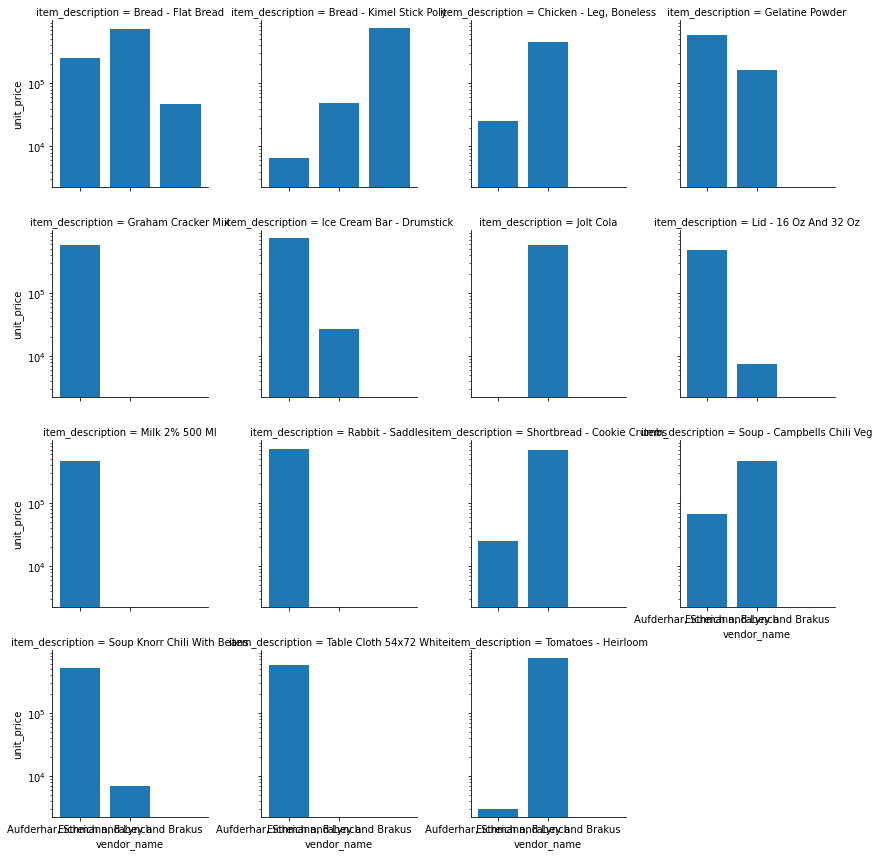

In [210]:
# observing unit price variations for same items purchased from different vendors

recurring_items = po_df[po_df.duplicated(subset='item_description', keep = False)].sort_values(by = 'item_description')

high_unit_price = recurring_items.sort_values(by = 'unit_price', ascending=False).head(15).item_description.values

item_variation =  recurring_items[recurring_items.item_description.isin(high_unit_price)]

g = sb.FacetGrid(data = item_variation, col = 'item_description', margin_titles =True, col_wrap = 4)
g.map(plt.bar, 'vendor_name', 'unit_price');

plt.yscale('log')

Wide variation in unit prices of same items procured from different vendors can be observed

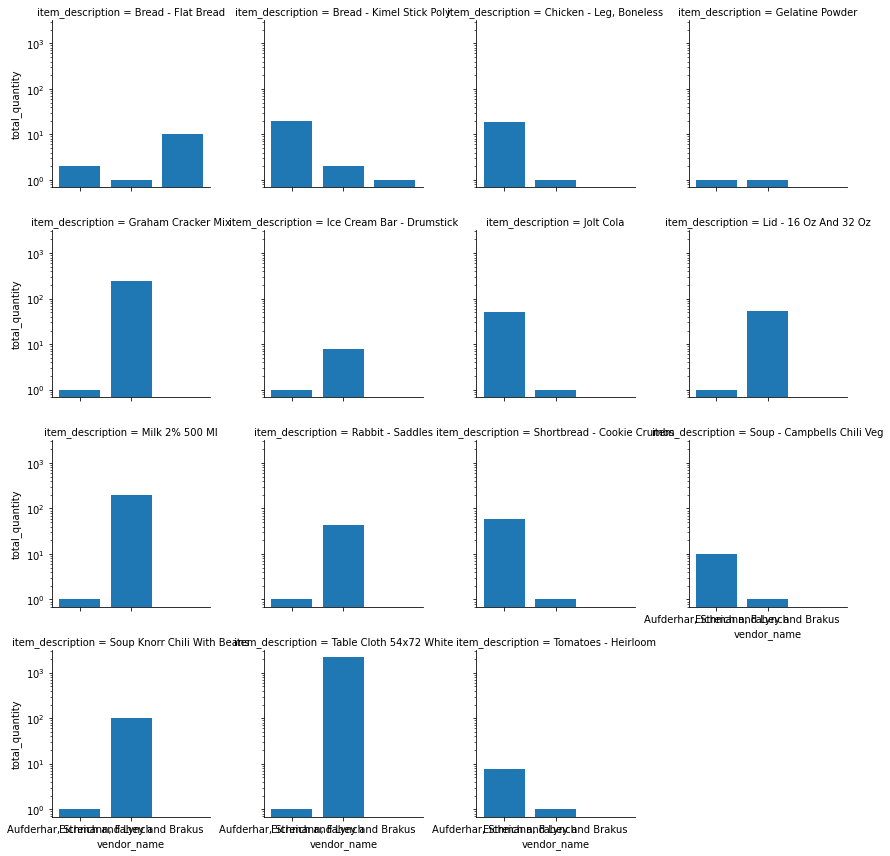

In [211]:
# observing quantity variations for same items purchased from different vendors

g = sb.FacetGrid(data = item_variation, col = 'item_description', margin_titles =True, col_wrap = 4)
g.map(plt.bar, 'vendor_name', 'total_quantity');

plt.yscale('log')

A healthy trend of procuring more quantities from vendors offering lower prices can be noted when comparing the above two grids. Note that plotting of bars have the same order so same vendor location. Example: Milk 2% 500 Ml (2nd row from bottom).

In [212]:
# observing change over time in unit price when procuring same items from different vendors

item_variation.groupby(['item_description', 'po_date', 'unit_price', 'vendor_name'])['total_quantity'].sum().head(20)

item_description           po_date     unit_price  vendor_name                  
Bread - Flat Bread         2018-10-16  255306      Thiel-Labadie                      2.0
                           2019-03-14  46947       Dickens-Dare                      10.0
                           2020-11-01  722822      Ortiz Inc                          1.0
Bread - Kimel Stick Poly   2019-01-18  49519       Aufderhar, Streich and Lynch       2.0
                           2019-08-12  755448      Padberg-Towne                      1.0
                           2020-01-17  6606        Metz-Boehm                        20.0
Chicken - Leg, Boneless    2019-10-02  25394       Ullrich-Emard                     19.0
                           2020-07-20  459275      Mills-Smith                        1.0
Gelatine Powder            2018-02-26  591730      Jerde, Kshlerin and Goldner        1.0
                           2020-12-24  162391      Bechtelar LLC                      1.0
Graham Cracker Mix 

It's apparent that higher unit prices are associated with lower purchase quantities. While there is a healthy trend of procuring more quantities from vendors offering lower prices, still the acquired discount (on higher quantities) does not justify the wide variation in unit prices between vendors.

Moreover, it is not clear why does the company procure from vendors offering higher prices after dealing with vendors offering lower ones (example: Chicken - Leg, Boneless, Lid - 16 Oz And 32 Oz, Milk 2% 500 Ml); could be quality, product availability or other terms and conditions issues but still this raise concerns on effectiveness of supplier selection and qualification process.

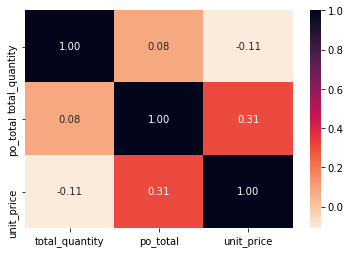

In [213]:
# Heat map of PO numeric details (value, quantity and unit price)

po_num_stats = po_df.columns[6:]

sb.heatmap(po_df[po_num_stats].corr(), cmap = 'rocket_r', annot = True, fmt ='.2f');

The heat map confirms earlier observation of negative correlation between quantity and unit price which is a logical and expected relationship, however it is not a strong one due to the staggering price variations among vendors.

## Summary of Initial findings

Several duplicated records were noted suggesting that Initial supplier registration does not follow a systematic usage of naming conventions; The ERP system does not detect duplicated vendor details.

Access rights are not properly managed. A total of 42 records were modified by unauthorized personnel of which 62% are active employees; product management department had most edits followed by marketing and R&D departments respectively. 

User account management is also experiencing a significant control weakness as 3 records were edited by personnel after their termination data; there might be failure to enforce group policies on local machines which could lead to internal breaches.

The fact that there are no POs issued to vendors with highly similar details across all records implies that theses could be unintentional errors and not directed towards manipulating purchase transactions.

Variation in unit prices of same items purchased from different vendors is alarming; the difference in unit price is staggering and was noted in several types of products among different vendors.

## Conclusion

We started off with a focused review of specific procurement procedures and we ended up with a need to branch in a full review of procurement process, as well as IT department’s practices for access rights and user account management procedures.